image balancing per class without augmentation

image balancing with augmentation - 
1. balancing is done usingn average of images per class. then the class has lower images, generate new images using augmentation
2. for the class has more number of images, down sampling is done for them to randomly select the images.

In [4]:
# !pip install wrapt
# !pip install rich
# !pip install h5py

Train folder path: c:\Users\amank\OneDrive\Desktop\ML_project\My\train
Balanced train folder path: c:\Users\amank\OneDrive\Desktop\ML_project\My\balanced_train
Original image counts per class:
Acne and Rosacea Photos: 840
Atopic Dermatitis Photos: 489
Eczema Photos: 1235
Herpes HPV and other STDs Photos: 405
Melanoma Skin Cancer Nevi and Moles: 463
Poison Ivy Photos and other Contact Dermatitis: 260
Psoriasis pictures Lichen Planus and related diseases: 1405
Urticaria Hives: 212
Vascular Tumors: 482
Warts Molluscum and other Viral Infections: 1086


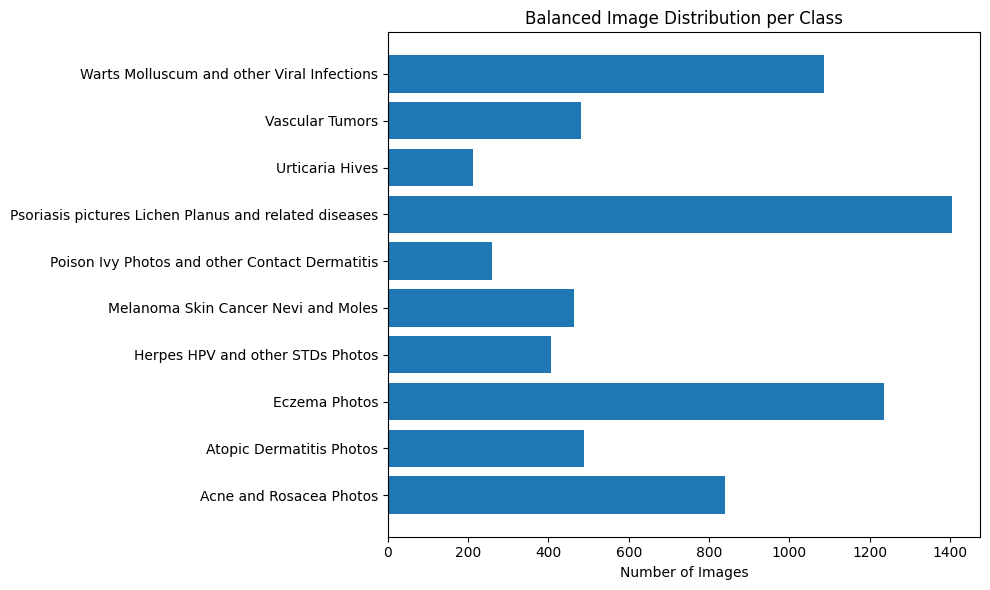

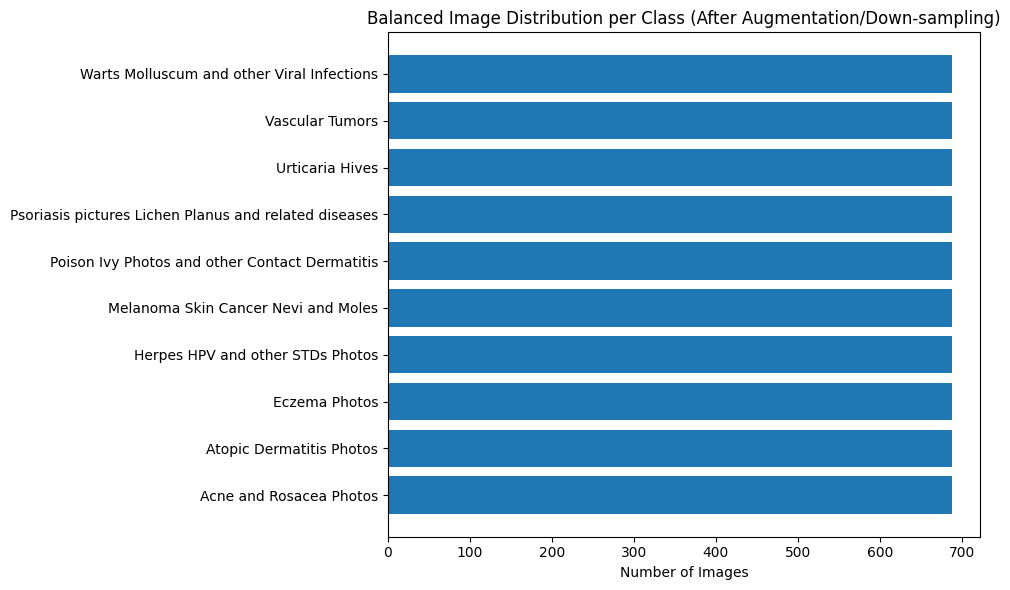

Final image counts per class:
Acne and Rosacea Photos: 688
Atopic Dermatitis Photos: 688
Eczema Photos: 688
Herpes HPV and other STDs Photos: 688
Melanoma Skin Cancer Nevi and Moles: 688
Poison Ivy Photos and other Contact Dermatitis: 688
Psoriasis pictures Lichen Planus and related diseases: 688
Urticaria Hives: 688
Vascular Tumors: 688
Warts Molluscum and other Viral Infections: 688


In [5]:
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt

def balance_dataset(train_folder, balanced_folder, max_augmentations_per_image=5):
    # Create balanced folder
    os.makedirs(balanced_folder, exist_ok=True)
    
    # List classes and calculate image counts
    disease_classes = os.listdir(train_folder)
    image_counts = {disease: len(os.listdir(os.path.join(train_folder, disease))) for disease in disease_classes}
    
    # Calculate the average number of images per class
    total_images = sum(image_counts.values())
    num_classes = len(disease_classes)
    average_images = round(total_images / num_classes)
    
    # Print original image counts per class before augmentation
    print("Original image counts per class:")
    for disease, count in image_counts.items():
        print(f"{disease}: {count}")

    # Visualization of balanced dataset
    img_counts = [len(os.listdir(os.path.join(train_folder, disease))) for disease in disease_classes]
    plt.figure(figsize=(10, 6))
    plt.barh(disease_classes, img_counts)
    plt.xlabel('Number of Images')
    plt.title('Balanced Image Distribution per Class')
    plt.tight_layout()
    plt.show()
    
    # Initialize data generator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Process each disease class
    for disease in disease_classes:
        class_folder = os.path.join(train_folder, disease)
        balanced_class_folder = os.path.join(balanced_folder, disease)
        os.makedirs(balanced_class_folder, exist_ok=True)
        
        images = os.listdir(class_folder)
        
        # Down-sample for classes with more images than the average
        if len(images) > average_images:
            selected_images = random.sample(images, average_images)  # Select random images
            for image in selected_images:
                shutil.copy(os.path.join(class_folder, image), balanced_class_folder)
        else:
            # Copy existing images if fewer than the average
            for image in images:
                shutil.copy(os.path.join(class_folder, image), balanced_class_folder)
            
            # Augment images to reach the target number
            while len(os.listdir(balanced_class_folder)) < average_images:
                for image in images:
                    # Break if we've reached the target number of images
                    if len(os.listdir(balanced_class_folder)) >= average_images:
                        break
                    
                    img_path = os.path.join(class_folder, image)
                    img = load_img(img_path)
                    x = img_to_array(img)
                    x = x.reshape((1,) + x.shape)
                    
                    # Generate augmented images per original image
                    augmented_count = 0
                    for batch in datagen.flow(x, batch_size=1, save_to_dir=balanced_class_folder,
                                               save_prefix='aug', save_format='jpeg'):
                        augmented_count += 1
                        # Break if target number of images is reached or we hit max augmentation limit
                        if len(os.listdir(balanced_class_folder)) >= average_images or augmented_count >= max_augmentations_per_image:
                            break
    

    balanced_counts = [average_images for disease in disease_classes]  # All should be equal to average_images now
    plt.figure(figsize=(10, 6))
    plt.barh(disease_classes, balanced_counts)
    plt.xlabel('Number of Images')
    plt.title('Balanced Image Distribution per Class (After Augmentation/Down-sampling)')
    plt.tight_layout()
    plt.show()
    
    # Print out the final image counts (after augmentation) per class
    print("Final image counts per class:")
    for disease in disease_classes:
        print(f"{disease}: {average_images}")  # All should be equal to average_images now
import os

# Define paths
train_folder = "train"
balanced_folder = "balanced_train"

# Ensure the directories exist
if not os.path.exists(train_folder):
    os.makedirs(train_folder)

if not os.path.exists(balanced_folder):
    os.makedirs(balanced_folder)

print(f"Train folder path: {os.path.abspath(train_folder)}")
print(f"Balanced train folder path: {os.path.abspath(balanced_folder)}")
# Run the balancing process
balance_dataset(train_folder, balanced_folder)


In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2

# Function to adjust brightness
def adjust_brightness(image, factor=1.2):
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

# Function to preprocess balanced data
def preprocess_and_save_data(balanced_folder, output_folder, img_size=(128, 128), brightness_factor=1.2):
    # Initialize containers for images and labels
    images = []
    labels = []
    class_names = sorted(os.listdir(balanced_folder))  # To keep consistent ordering of classes
    class_mapping = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    print("Loading, preprocessing, and saving images from balanced data...")
    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(balanced_folder, class_name)
        image_files = os.listdir(class_folder)
        
        # Create corresponding class folder in the output directory
        output_class_folder = os.path.join(output_folder, class_name)
        os.makedirs(output_class_folder, exist_ok=True)
        
        for image_file in image_files:
            img_path = os.path.join(class_folder, image_file)
            # Load and resize the image
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            
            # Apply brightness adjustment
            img_array = adjust_brightness(img_array, factor=brightness_factor)
            
            # Normalize pixel values to [0, 1]
            img_array_normalized = img_array / 255.0
            images.append(img_array_normalized)
            labels.append(class_mapping[class_name])  # Add numeric label
            
            # Save the preprocessed image
            output_img_path = os.path.join(output_class_folder, image_file)
            cv2.imwrite(output_img_path, cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR))  # Save in BGR format
            
    # Convert to numpy arrays
    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int")
    
    # One-hot encode the labels
    labels_one_hot = to_categorical(labels, num_classes=len(class_names))
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
    
    print(f"Data split: {len(X_train)} training samples, {len(X_val)} validation samples")
    print(f"Class mapping: {class_mapping}")
    
    # Optional data augmentation for the training set
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    
    # Validation data generator (only rescaling)
    val_datagen = ImageDataGenerator()
    
    # Create training and validation generators
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
    
    return train_generator, val_generator, class_mapping

# Set the balanced folder path
balanced_folder = "balanced_train"
output_folder = "preprocessed_data"  # Folder to save preprocessed images

# Preprocess the data and save preprocessed images
train_generator, val_generator, class_mapping = preprocess_and_save_data(
    balanced_folder, 
    output_folder, 
    img_size=(128, 128), 
    brightness_factor=1.2  # Adjust this factor to tune brightness enhancement
)

# Verify the class mapping
print(f"Class mapping: {class_mapping}")


Loading, preprocessing, and saving images from balanced data...
Data split: 6659 training samples, 1665 validation samples
Class mapping: {'Acne and Rosacea Photos': 0, 'Atopic Dermatitis Photos': 1, 'Eczema Photos': 2, 'Herpes HPV and other STDs Photos': 3, 'Melanoma Skin Cancer Nevi and Moles': 4, 'Poison Ivy Photos and other Contact Dermatitis': 5, 'Psoriasis pictures Lichen Planus and related diseases': 6, 'Urticaria Hives': 7, 'Vascular Tumors': 8, 'Warts Molluscum and other Viral Infections': 9}
Class mapping: {'Acne and Rosacea Photos': 0, 'Atopic Dermatitis Photos': 1, 'Eczema Photos': 2, 'Herpes HPV and other STDs Photos': 3, 'Melanoma Skin Cancer Nevi and Moles': 4, 'Poison Ivy Photos and other Contact Dermatitis': 5, 'Psoriasis pictures Lichen Planus and related diseases': 6, 'Urticaria Hives': 7, 'Vascular Tumors': 8, 'Warts Molluscum and other Viral Infections': 9}


**HOG**

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage.feature import hog, local_binary_pattern

# 1. Data Preparation
def load_images_and_labels(data_folder, img_size=(128, 128)):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_folder))
    print("Loading images and labels...")
    for class_name in tqdm(class_names, desc="Classes"):
        class_folder = os.path.join(data_folder, class_name)
        image_files = os.listdir(class_folder)
        for image_file in image_files:
            img_path = os.path.join(class_folder, image_file)
            # Load image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize image
                img_resized = cv2.resize(img, img_size)
                images.append(img_resized)
                labels.append(class_name)
    return images, labels

# Load images and labels
data_folder = 'preprocessed_data'  # Update this path if necessary
images, labels = load_images_and_labels(data_folder)

# 2. Feature Extraction using HOG and LBP
def extract_features(images):
    hog_features = []
    lbp_features = []
    print("Extracting features...")
    for img in tqdm(images, desc="Extracting Features"):
        # HOG features
        hog_feat = hog(
            img, 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            block_norm='L2-Hys', 
            transform_sqrt=True, 
            feature_vector=True
        )
        hog_features.append(hog_feat)
        
        # LBP features
        lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
        # Build a histogram of LBP
        (hist, _) = np.histogram(
            lbp.ravel(),
            bins=np.arange(0, lbp.max() + 1),
            range=(0, lbp.max())
        )
        # Normalize the histogram
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)
        lbp_features.append(hist)
    
    # Concatenate HOG and LBP features
    features = np.hstack([hog_features, lbp_features])
    return features

features = extract_features(images)
print(f"Feature matrix shape: {features.shape}")

# 3. Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 4. Encode Labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
class_names = label_encoder.classes_
num_classes = len(class_names)
print(f"Classes: {class_names}")

# 5. Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    features_scaled, 
    labels_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels_encoded
)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


Loading images and labels...


Classes: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Extracting features...


Extracting Features: 100%|██████████| 8324/8324 [01:23<00:00, 99.80it/s] 


Feature matrix shape: (8324, 8109)
Classes: ['Acne and Rosacea Photos' 'Atopic Dermatitis Photos' 'Eczema Photos'
 'Herpes HPV and other STDs Photos' 'Melanoma Skin Cancer Nevi and Moles'
 'Poison Ivy Photos and other Contact Dermatitis'
 'Psoriasis pictures Lichen Planus and related diseases' 'Urticaria Hives'
 'Vascular Tumors' 'Warts Molluscum and other Viral Infections']
Training samples: 6659, Validation samples: 1665


In [3]:

# 6. Define Functions for Plotting and Progress
from sklearn.model_selection import StratifiedKFold

def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring='accuracy',
        verbose=1  # Set verbose to display progress
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training accuracy')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Validation accuracy')
    
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_true, y_proba, n_classes, classifier_name):
    y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(
            fpr[i], tpr[i], 
            label='Class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i])
        )
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [4]:

def train_and_evaluate_classifier(clf, clf_name):
    print(f"\nTraining {clf_name} classifier...")
    with tqdm(total=1, desc=f"Fitting {clf_name}") as pbar:
        clf.fit(X_train, y_train)
        pbar.update(1)
    y_pred = clf.predict(X_val)
    
    # For classifiers that support probability estimates
    if hasattr(clf, "predict_proba"):
        y_pred_proba = clf.predict_proba(X_val)
    else:
        # For classifiers like SVC with probability=False, use decision_function
        y_pred_proba = clf.decision_function(X_val)
        # If it's a binary classifier, convert to two columns
        if len(clf.classes_) == 2:
            y_pred_proba = np.vstack([
                1 - y_pred_proba, y_pred_proba
            ]).T
    
    # Accuracy
    acc = accuracy_score(y_val, y_pred)
    print(f"{clf_name} Accuracy: {acc:.4f}")
    
    # Classification Report
    print(f"{clf_name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names))
    
    # ROC AUC Score
    if num_classes > 2:
        y_val_binarized = label_binarize(y_val, classes=np.arange(num_classes))
        roc_auc = roc_auc_score(y_val_binarized, y_pred_proba, average='macro', multi_class='ovr')
    else:
        roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])
    print(f"{clf_name} ROC AUC Score: {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', 
        xticklabels=class_names, 
        yticklabels=class_names, 
        cmap='Blues'
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{clf_name} Confusion Matrix')
    plt.show()
    
    # Plot Learning Curve
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    plot_learning_curve(
        clf, 
        f'Learning Curve for {clf_name}', 
        features_scaled, 
        labels_encoded, 
        cv=cv,
        n_jobs=-1
    )
    
    # Plot ROC Curve
    plot_roc_curve(y_val, y_pred_proba, num_classes, clf_name)




**SVC**


Training Support Vector Machine classifier...


Fitting Support Vector Machine: 100%|██████████| 1/1 [32:30<00:00, 1950.27s/it]


Support Vector Machine Accuracy: 0.3387
Support Vector Machine Classification Report:
                                                       precision    recall  f1-score   support

                              Acne and Rosacea Photos       0.34      0.29      0.31       167
                             Atopic Dermatitis Photos       0.47      0.10      0.17       137
                                        Eczema Photos       0.36      0.48      0.41       226
                     Herpes HPV and other STDs Photos       0.37      0.16      0.22       137
                  Melanoma Skin Cancer Nevi and Moles       0.45      0.49      0.47       138
       Poison Ivy Photos and other Contact Dermatitis       0.35      0.37      0.36       138
Psoriasis pictures Lichen Planus and related diseases       0.26      0.52      0.34       241
                                      Urticaria Hives       0.55      0.34      0.42       138
                                      Vascular Tumors     

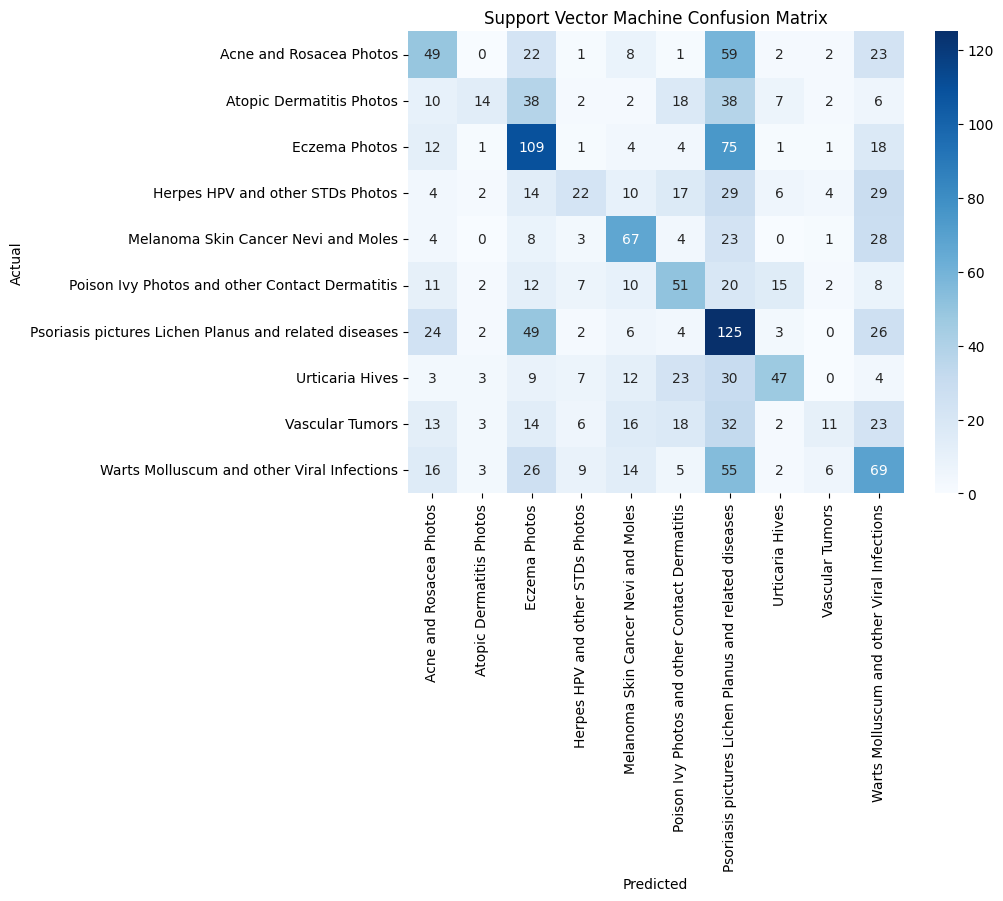

[learning_curve] Training set sizes: [ 665 1331 1997 2663 3329 3995 4661 5327 5993 6659]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

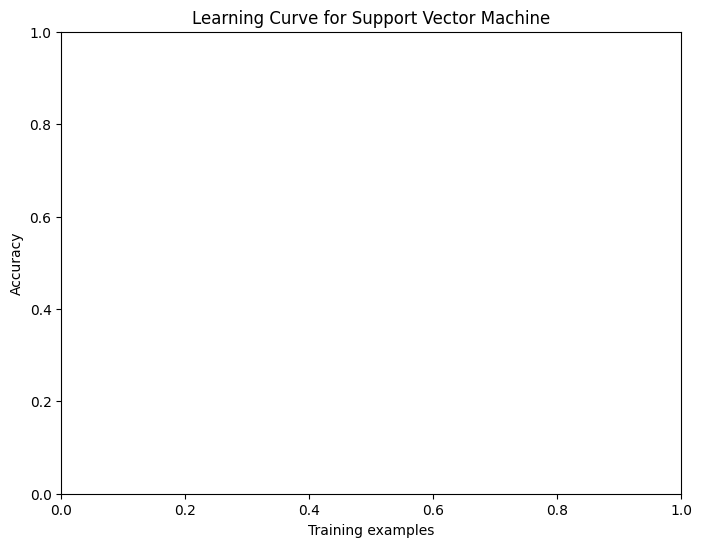

In [6]:
# Initialize classifiers

svc_classifier = SVC(kernel='rbf', probability=True, random_state=42)



# Train and evaluate SVC
train_and_evaluate_classifier(svc_classifier, 'Support Vector Machine')


**KNN**


Training K-Nearest Neighbors classifier...


Fitting K-Nearest Neighbors: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


K-Nearest Neighbors Accuracy: 0.1970
K-Nearest Neighbors Classification Report:
                                                       precision    recall  f1-score   support

                              Acne and Rosacea Photos       0.23      0.39      0.29       167
                             Atopic Dermatitis Photos       0.11      0.22      0.15       137
                                        Eczema Photos       0.25      0.23      0.24       226
                     Herpes HPV and other STDs Photos       0.09      0.02      0.04       137
                  Melanoma Skin Cancer Nevi and Moles       0.19      0.14      0.16       138
       Poison Ivy Photos and other Contact Dermatitis       0.31      0.12      0.17       138
Psoriasis pictures Lichen Planus and related diseases       0.21      0.29      0.24       241
                                      Urticaria Hives       0.21      0.11      0.14       138
                                      Vascular Tumors       0.30

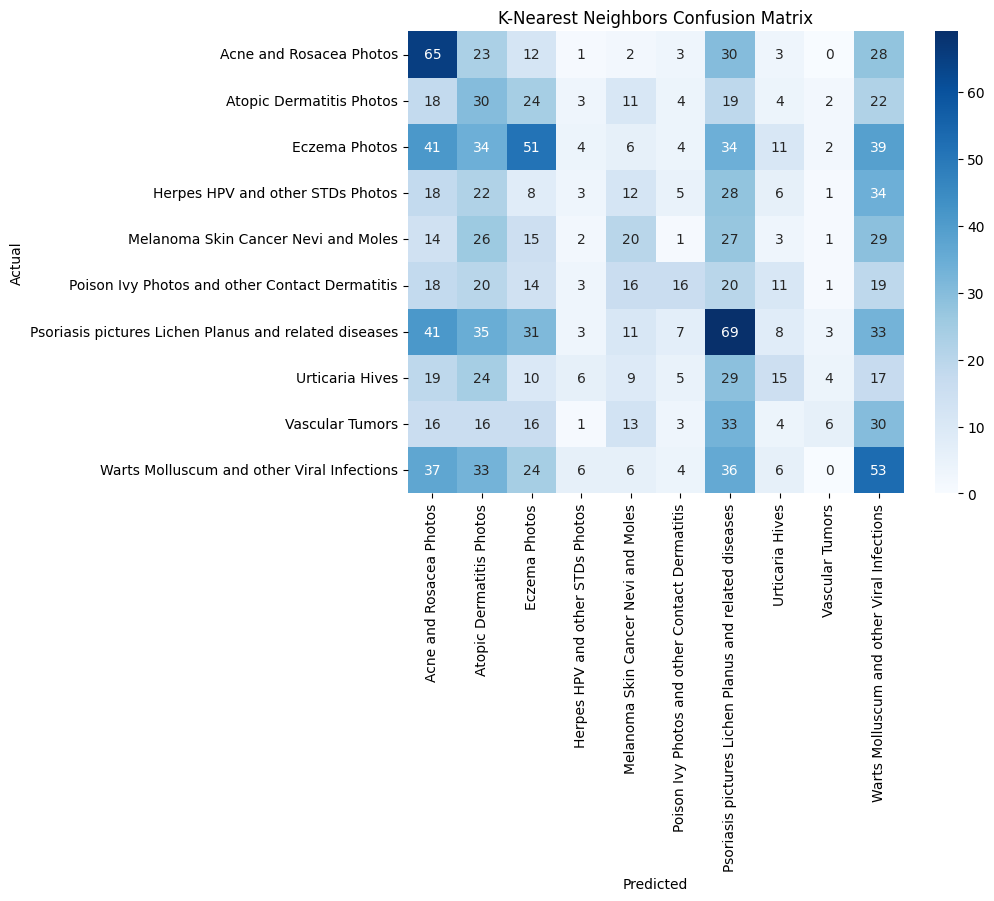

[learning_curve] Training set sizes: [ 665 1331 1997 2663 3329 3995 4661 5327 5993 6659]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished


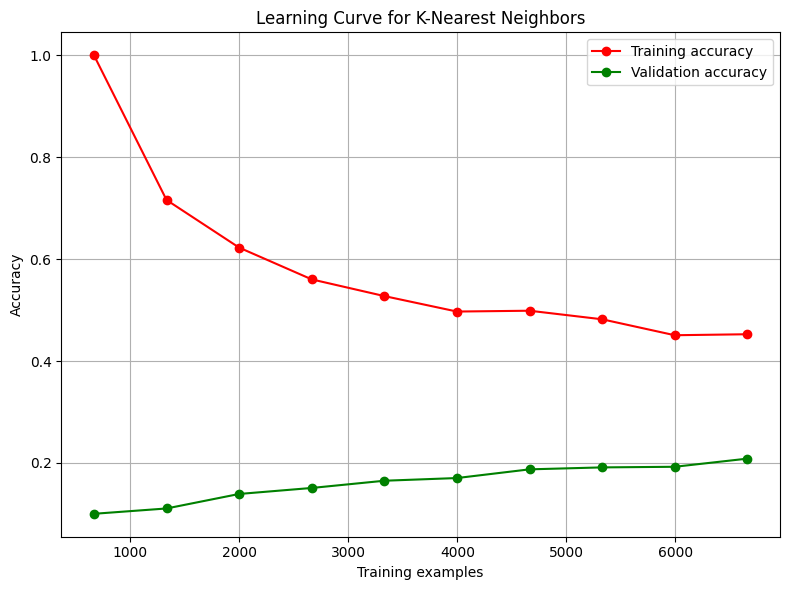

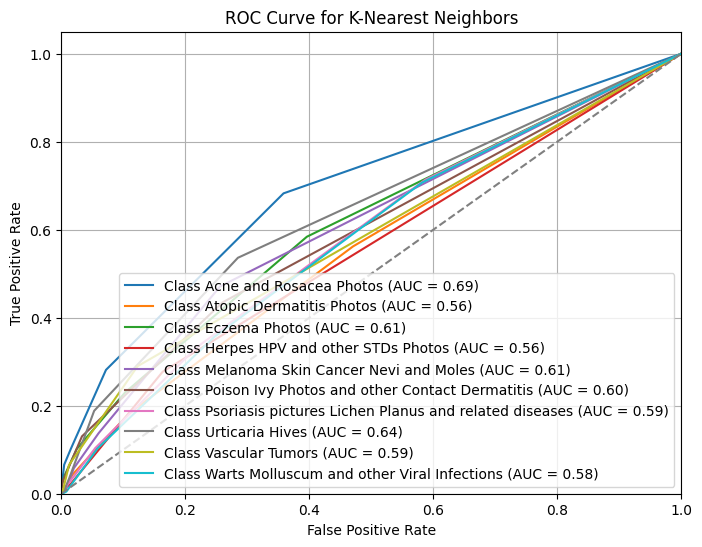

In [5]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train and evaluate KNN
train_and_evaluate_classifier(knn_classifier, 'K-Nearest Neighbors')

from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
)
)
